<a href="https://colab.research.google.com/github/PavelPimKot/-High-Performance-Computing-Lab1/blob/main/Lab1_vector_sum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import time
import sys
import matplotlib.pyplot as plt
import numpy as np
from numba import cuda, int32
from tabulate import tabulate

TPB = 16
ITER_COUNT = 8
EPS = sys.float_info.epsilon

vec_size_min = 1000
vec_size_max = 1000000
vec_size_interval = 100000

Задаем количество нитей на блок, количество итераций пересчета вычислений, а так же максимальные и минимальные размеры массивов + шаг увеличения размеров.

In [ ]:
@cuda.jit
def gpu_vec_sum(vec, res):
    tx = cuda.threadIdx.x
    bx = cuda.blockIdx.x
    idx = tx + bx * TPB
    if idx < vec.shape[0]:
      cuda.atomic.add(res, 0, vec[idx]) 

Функция вычисления суммы вектора на GPU, каждая нить выполняет 1 вычисление, запись в общую переменную res идет через cuda.atomic.add (единовременно выполняется только одной нитью)

In [ ]:
def cpu_vec_sun(vec):
    result =0
    for i in range(vec.shape[0]):
      result += vec[i]
    return result

сумма вектора на cpu, просто цикл суммирования элементов массива в переменную.

In [ ]:
def vector_sum():
    results = [] 
    for vec_size in range(vec_size_min, vec_size_max + 1, vec_size_interval):
        for _ in range(ITER_COUNT):
            # vec = np.random.randint(1000, size=vec_size)
            vec = np.ones(vec_size)
            gpu_result = np.zeros(1, dtype=np.int32)

            device_vec = cuda.to_device(vec)
            device_res = cuda.to_device(gpu_result)
            gpu_start = time.time() 
            gpu_vec_sum[int((vec_size + TPB) / TPB), TPB](device_vec, device_res)
            gpu_time = time.time() - gpu_start
            gpu_result = device_res.copy_to_host()

            cpu_start = time.time()
            cpu_result = cpu_vec_sun(vec)
            cpu_time = time.time() - cpu_start

        result = [vec_size, gpu_result[0], cpu_result, cpu_time / ITER_COUNT, gpu_time / ITER_COUNT]
        results.append(result)

    print(tabulate(results, headers=['vector size', 'resul_gpu', 'resul_cpu', 'cpu, ms', 'gpu, ms']))

    vec_sizes = list(map(lambda x: x[0], results))
    cpu_times = list(map(lambda x: x[2], results))
    gpu_times = list(map(lambda x: x[3], results))
    accelerations = list(map(lambda x: x[2] / (x[3] if x[3] > EPS else EPS), results))

    plt.figure(figsize=(18,4))
    plt.subplot(1, 3, 1)
    plt.title("cpu")
    plt.plot(vec_sizes, cpu_times)
    plt.xlabel("vector size")
    plt.ylabel("time, ms")
    plt.grid()

    plt.subplot(1, 3, 2)
    plt.title("gpu")
    plt.plot(vec_sizes, gpu_times)
    plt.xlabel("vector size")
    plt.ylabel("time, ms")
    plt.grid()

    plt.subplot(1, 3, 3)
    plt.title("acceleration")
    plt.plot(vec_sizes, accelerations)
    plt.xlabel("vector size")
    plt.ylabel("cpu to gpu time ratio")
    plt.grid()

    plt.show()

Мейн функция, делаем вычисления + собираем информацию по времени выполнения обоих функций, далее собранный массив данных используем для графиков времени выполнения на GPU, CPU, а так же для построения графика ускорения.

  vector size    resul_gpu    resul_cpu      cpu, ms      gpu, ms
-------------  -----------  -----------  -----------  -----------
         1000         1000         1000  1.82092e-05  1.08778e-05
       101000       101000       101000  0.00189352   1.24872e-05
       201000       201000       201000  0.0040347    2.17259e-05
       301000       301000       301000  0.00604928   1.78516e-05
       401000       401000       401000  0.00697303   2.08616e-05
       501000       501000       501000  0.0101331    3.01301e-05
       601000       601000       601000  0.0136082    2.09808e-05
       701000       701000       701000  0.0121581    1.89841e-05
       801000       801000       801000  0.0139714    1.96099e-05
       901000       901000       901000  0.0188282    1.87457e-05


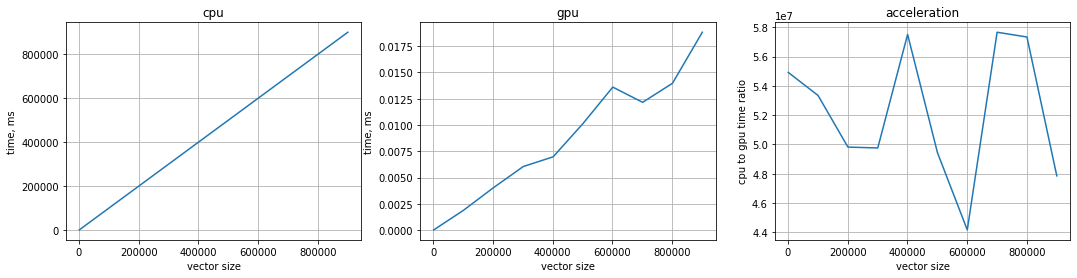

In [ ]:
vector_sum()